### IE801 물류관리 HW2

- 이름 : 이강훈
- 학번 : 20203421

In [37]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import copy

import gurobipy as gp
from gurobipy import GRB
from itertools import product

### Problem 1 : Generate TSP instances of n=20, 50, 100 randomly.

    
- generate_instance
    - 도시의 갯수를 받아서 그에 따른 정수 기반 위치를 반환.
    
    
- visualize_points
    - 도시들의 (x, y) 좌표를 받아서 visualize
    - tour path도 넘겨주면 그에 따른 path도 visualize.

In [38]:
def generate_instance(num_nodes):
    x = np.random.randint(100, size=num_nodes)
    y = np.random.randint(100, size=num_nodes)
    return x, y

In [39]:
def visualize_points(x, y, title=None, tour=None):

    border = 5
    plt.xlim(0 - border, 100 + border)
    plt.ylim(0 - border, 100 + border)
    
    plt.xticks([])
    plt.yticks([])
    
    if title:
        plt.title(title)
    
    if tour is None:
        plt.scatter(x, y)
    else:
        plt.plot(x[tour], y[tour], marker='o')
        
    plt.show()
    plt.close('all')

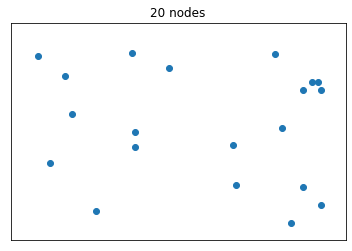

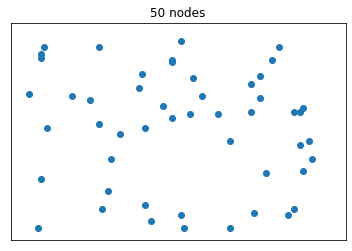

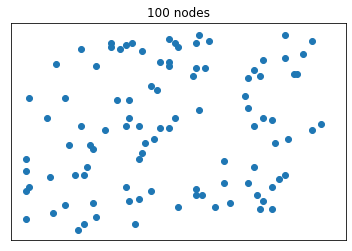

In [40]:
x, y = generate_instance(20)
visualize_points(x, y, "20 nodes")

x, y = generate_instance(50)
visualize_points(x, y, "50 nodes")

x, y = generate_instance(100)
visualize_points(x, y, "100 nodes")

### Problem 2 : Solve the problems using Gurobi and lazy constraints.

![nn](./Images/HW2_image1.png)

Reference : https://www.gurobi.com/documentation/9.1/examples/tsp_py.html

- get_cost
    - 도시들의 (x, y) 좌표를 받아서 i 도시에서 j 도시까지의 거리를 계산한 numpy array를 반환.
    
    
- subtourelim
    - TSP MILP 문제를 풀다가 solution을 찾게 되면 call 되는 function. 
    - subtour의 존재여부를 파악한 뒤, 만약 존재하면 subtour를 제거할 수 있도록 그에 맞는 constraint (2.11) 를 추가.
    - lazy constraint가 적용되는 부분.
    
    
- subtour
    - edge들간의 연결관계를 받아서, 가장 작은 subtour를 반환.
    
    
- solve_TSP
    - 도시들의 (x, y) 좌표를 받아서 minimum cost tour path를 반환. 
    - solve TSP MILP with gurobi.
    - (2.8), (2.9), (2.10), (2.12) 식이 구현되어 있음.

In [81]:
def get_cost(x, y, integer=False):
    
    x_ = x.copy().reshape(-1, 1)
    y_ = y.copy().reshape(-1, 1)
    cost = np.sqrt((x - x_) ** 2 + (y - y_) ** 2)

    if integer:
        return np.round(cost, 0).astype(dtype=np.int64)
    else:
        return cost

In [42]:
def subtourelim(model, where):
    if where == GRB.Callback.MIPSOL:
        # make a list of edges selected in the solution
        vals = model.cbGetSolution(model._vars)
        selected = gp.tuplelist((i, j) for i, j in model._vars.keys() if vals[i, j] > 0.5)
        # find the shortest cycle in the selected edge list
        n = int(model.ModelName)
        tour = subtour(selected, n)
        
        if len(tour) < n:
            out_nodes = list(set(range(n)) - set(tour))
            in_nodes = tour
            model.cbLazy(gp.quicksum(model._vars[i, j] for i, j in product(out_nodes, in_nodes)) >= 1)

In [43]:
def subtour(edges, n):
    unvisited = list(range(n))
    cycle = range(n+1)  # initial length has 1 more city
    while unvisited:  # true if list is non-empty
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i, j in edges.select(current, '*') if j in unvisited]
        if len(cycle) > len(thiscycle):
            cycle = thiscycle
    return cycle

In [44]:
def solve_TSP(x, y):
    num_nodes = x.shape[0]
    cost = get_cost(x, y)
    
    model = gp.Model(name=str(num_nodes))
    model.Params.LogToConsole = 0
    variables = gp.tupledict()

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                variables[i, j] = model.addVar(obj=cost[i][j], vtype=GRB.BINARY, name=str(num_nodes))

    for i in range(num_nodes):
        temp_list = list(range(num_nodes))
        temp_list.pop(i)
        model.addConstr(sum(variables[i, j] for j in temp_list) == 1)
        model.addConstr(sum(variables[j, i] for j in temp_list) == 1)

    model._vars = variables
    model.Params.lazyConstraints = 1
    model.optimize(subtourelim)

    vals = model.getAttr('x', variables)
    selected = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5)

    tour = subtour(selected, num_nodes)
    assert len(tour) == num_nodes
    
    tour = tour + [0]
    return tour, model.objVal

Academic license - for non-commercial use only - expires 2022-09-19
Using license file C:\Users\Kanghoon\gurobi.lic


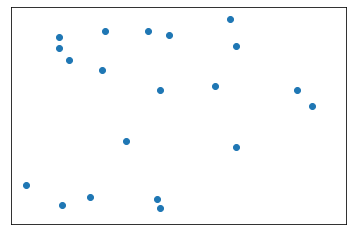

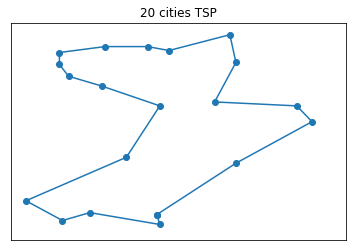

In [45]:
x, y = generate_instance(20)
tour, cost = solve_TSP(x, y)

visualize_points(x, y)
visualize_points(x, y, '20 cities TSP', tour)

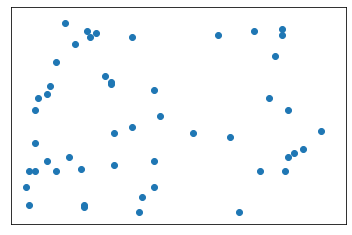

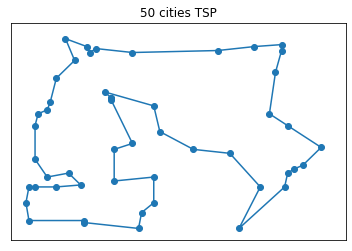

In [46]:
x, y = generate_instance(50)
tour, cost = solve_TSP(x, y)

visualize_points(x, y)
visualize_points(x, y, '50 cities TSP', tour)

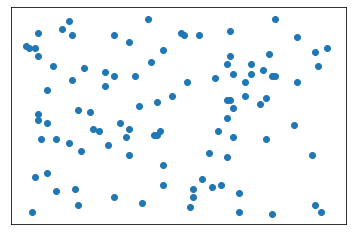

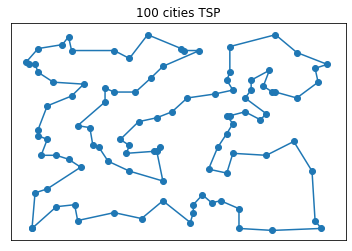

In [47]:
x, y = generate_instance(100)
tour, cost = solve_TSP(x, y)

visualize_points(x, y)
visualize_points(x, y, '100 cities TSP', tour)

### Problem 3 : Solve the problems using the Concorde and LKH solvers.

In [48]:
%load_ext julia.magic

The julia.magic extension is already loaded. To reload it, use:
  %reload_ext julia.magic


In [84]:
%julia using PyCall

%julia using Concorde
%julia using LKH

In [56]:
%%julia

M = [
     0  16   7  14
    16   0   3   5
     7   3   0  16
    14   5  16   0 
]

opt_tour, opt_len = solve_tsp(M)

(array([1, 3, 2, 4], dtype=int64), 29)

In [69]:
a = %julia opt_tour
b = 324234
k = %julia M
print(k.dtype)
print(type(a), type(k))

int64
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [60]:
%%julia


a = py"""x"""

array([ 2, 99,  5, 62, 66, 29, 70, 10, 43, 14, 41, 68, 10, 72, 57, 19, 96,
       79,  7, 29, 55,  4, 72, 34, 31, 82, 61,  7, 81, 68, 79, 95, 48, 34,
       55, 89, 22, 27, 12, 67, 60, 45, 94, 16, 44, 81, 33, 67, 66, 29,  3,
       70, 80, 74,  4, 43, 97, 88, 24, 21,  0, 54,  1, 17,  7, 45, 66, 82,
        9, 45, 51, 15, 67, 37, 89, 68, 42, 66, 15, 63, 58, 78,  4, 74, 52,
       17, 53, 34,  3, 26,  4, 64, 95, 18, 77, 40, 26, 36, 14, 38],
      dtype=int32)

In [25]:
%%python

b = 3

In [71]:
x, y = generate_instance(5)
cost = get_cost(x, y)

In [82]:
print(cost)
we = np.round(cost, 0).astype(dtype=np.int64)
print(we)

[[ 0.         47.70744177 43.28972164 28.7923601  45.27692569]
 [47.70744177  0.         82.37718131 20.61552813 48.84669897]
 [43.28972164 82.37718131  0.         61.91122677 88.        ]
 [28.7923601  20.61552813 61.91122677  0.         47.42362281]
 [45.27692569 48.84669897 88.         47.42362281  0.        ]]
[[ 0 48 43 29 45]
 [48  0 82 21 49]
 [43 82  0 62 88]
 [29 21 62  0 47]
 [45 49 88 47  0]]
